In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from statsmodels.api import OLS, add_constant

In [6]:
data = pd.read_csv("data/fixed_data.csv")
data

,AUN_SUM,HEALTH,K6SCMON,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,SERVICE,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,1,1,0.666667,2,1.000000,4,2.0,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,0,1,0.333333,1,0.000000,4,1.0,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,1,1,0.333333,2,0.333333,4,2.0,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,0,1,0.666667,2,0.000000,1,2.0,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,0,1,0.333333,1,0.333333,4,2.0,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,1,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,0,0,0.333333,2,0.333333,1,2.0,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,1,0,0.666667,2,1.000000,1,2.0,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,0,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


In [8]:
# 결과 변수 목록
numeric_outcomes = ["AUN_SUM", "HEALTH", "K6SCMON"]

# 결과 저장
results = {}

# 수치형 결과 변수 처리
for outcome in numeric_outcomes:
    print(f"Estimating effect for numeric outcome (DiD + Parametric): {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X = data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

    # 성향 점수 계산 (Propensity Score)
    prop_model = LogisticRegression()
    prop_model.fit(X, T)
    propensity_scores = prop_model.predict_proba(X)[:, 1]

    # 처치와 성향 점수 추가
    X_with_ps = X.copy()
    X_with_ps['Propensity'] = propensity_scores
    X_with_ps['Post'] = Post
    X_with_ps['Treatment_Post'] = T * Post

    # 회귀 분석 (OLS)
    X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
    ols_model = OLS(Y, X_ols).fit()

    # ATE 추정
    ate = ols_model.params['Treatment_Post']
    ci = ols_model.conf_int().loc['Treatment_Post']

    # 결과 저장
    results[outcome] = {
        "ATE": ate,
        "CI": (ci[0], ci[1])
    }

    print(f"ATE for {outcome}: {ate}, CI: ({ci[0]}, {ci[1]})\\n")

# 최종 결과 출력
for outcome, result in results.items():
    print(f"Outcome: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")


Estimating effect for numeric outcome (DiD + Parametric): AUN_SUM
ATE for AUN_SUM: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)\n
Estimating effect for numeric outcome (DiD + Parametric): HEALTH
ATE for HEALTH: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)\n
Estimating effect for numeric outcome (DiD + Parametric): K6SCMON
ATE for K6SCMON: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)\n
Outcome: AUN_SUM, ATE: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)
Outcome: HEALTH, ATE: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)
Outcome: K6SCMON, ATE: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)


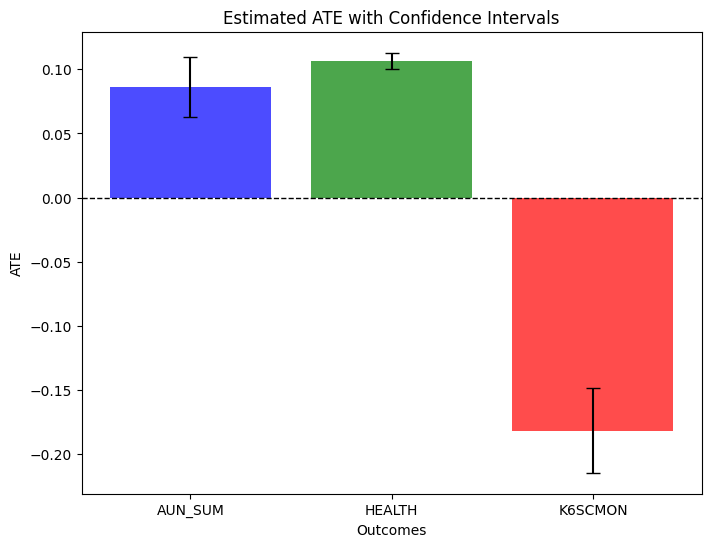

In [9]:
import matplotlib.pyplot as plt

# 시각화 데이터 준비
outcomes = list(results.keys())
ates = [results[outcome]["ATE"] for outcome in outcomes]
ci_lowers = [results[outcome]["CI"][0] for outcome in outcomes]
ci_uppers = [results[outcome]["CI"][1] for outcome in outcomes]

# 막대 그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(outcomes, ates, yerr=[np.array(ates) - np.array(ci_lowers), np.array(ci_uppers) - np.array(ates)],
        capsize=5, color=['blue', 'green', 'red'], alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Outcomes")
plt.ylabel("ATE")
plt.title("Estimated ATE with Confidence Intervals")
plt.show()
